In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers


import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from operator import itemgetter


In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [25]:
counterfact = CounterFactDataset("../data/")

Loaded dataset with 21919 elements


In [7]:
###################################################################################
final_layer_norm_name = "transformer.ln_f"
decoder_name = "lm_head"
###################################################################################

In [8]:
final_layer_norm = nethook.get_module(model, final_layer_norm_name)
decoder = nethook.get_module(model, decoder_name)

def get_vocab_representation(h, perform_layer_norm = True, return_top_k = 5):
    z = h.clone()
    if(perform_layer_norm == True):
        z = final_layer_norm(z)
    logits = decoder(z)
    token_ids = logits.topk(dim=-1, k=return_top_k).indices.squeeze().tolist()
    return [
        tokenizer.decode(t) for t in token_ids
    ]

In [77]:
###########################################################################
relation_dct = {
    'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
    'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
    'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
    'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
    'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
    # 'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
    'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
    'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
    'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
    'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
    'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
    'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
    'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
    'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
    'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
    'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
    'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
    'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
    'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
    'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
    'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
    'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
    'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
    'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
    'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
    'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
    'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
    'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
    'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

for relation in relation_dct:
    path = f"{root_path}/{relation}"
    if "performance" not in os.listdir(path):
        print("skipped ", relation)

skipped  P131
skipped  P407
skipped  P108


In [39]:
from typing import Any, Sequence, TypeAlias, List
Model: TypeAlias = transformers.GPT2LMHeadModel
Tokenizer: TypeAlias = transformers.PreTrainedTokenizerFast

def calculate_corner(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,
):
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    print(target_tokenized.input_ids.shape)

    tunable_weights = {}
    for n, p in model.named_parameters():
        if n.startswith(final_layer_norm_name) or n.startswith(decoder_name):
            tunable_weights[n] = p
            p.requires_grad = True
        else:
            p.requires_grad = False

    z = torch.FloatTensor(model.config.n_embd).uniform_(-.01 , .01).to(model.dtype).to(model.device)
    print("initial representation: ", get_vocab_representation(z))
    z.requires_grad = True

    optimizer = torch.optim.Adam(
        [z],
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    loss_track = []
    for iter in range(num_steps):
        logits = decoder(final_layer_norm(z))
        target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
        # print(target_logits)
        # loss = -target_logits.sum().square() #+ 1000 * entropy(target_logits) #+ logits.sum()

        optimal_logit_values = torch.zeros(target_logits.shape) + target_logit_value
        optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        loss = (optimal_logit_values - target_logits).square().mean() + logits.square().mean()

        # optimal_logit_values = torch.zeros(model.config.vocab_size) - 1
        # for t in target_tokenized.input_ids:
        #     optimal_logit_values[t[0]] = 10
        # optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # print(torch.gather(optimal_logit_values, 0, target_tokenized.input_ids.reshape(len(target_words))))
        # loss = (optimal_logit_values - logits).mean().square()
        
        loss_track.append(loss.item())
        # print(loss.item(), logits.mean().item(), target_logits.sum().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for t in tunable_weights:
            tunable_weights[t].grad.zero_()
    
    for t in tunable_weights:
        tunable_weights[t].requires_trad = False
    z.requires_grad = False
    print("final representation: ", get_vocab_representation(z))

    return z

In [56]:
#################################################
relation_id = "P17"
precision_at = 3
#################################################

In [57]:
with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
    correct_predictions = json.load(f)
print("correctly predicted: ", len(correct_predictions))

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects))

corner = calculate_corner(model, tokenizer, objects)

correctly predicted:  404
unique objects:  95
torch.Size([95, 1])
initial representation:  ['ONG', ' Patriot', ' bit', 'mad', 'Sep']
final representation:  [' Italy', ' Thailand', ' Nigeria', ' Egypt', ' Argentina']


In [58]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner
)

In [59]:
# test_subjects = [
#     "Hugh Jackman",
#     "Michael Phelps",
#     "Agatha Christie",
#     "Barack Obama",
#     "Sherlock Holmes",
#     "Alan Turing",
#     "Bill Gates",
#     "Michelangelo"
# ]

# for sub in test_subjects:
#     print(f"{sub} >> ", relation(sub, device= model.device))

In [65]:
correct_predictions[0]

{'prompt': '{}, which is located in',
 'relation_id': 'P17',
 'target_new': {'str': 'Sweden', 'id': 'Q34'},
 'target_true': {'str': 'Spain', 'id': 'Q29'},
 'subject': 'Autonomous University of Madrid'}

In [69]:
def get_most_frequent_objects(counterfact_requests):
    frequent_counter = {}
    for c in counterfact_requests:
        obj = c['target_true']['str']
        if(obj not in frequent_counter):
            frequent_counter[obj] = 0
        frequent_counter[obj] += 1

    lst = [(v, k) for k, v in frequent_counter.items()]
    lst = sorted(lst, reverse=True)
    most_frequent_predictions = [n for c, n in lst][: precision_at]

    return most_frequent_predictions

most_frequent_predictions = get_most_frequent_objects(correct_predictions)
most_frequent_predictions

['India', 'Japan', 'Poland']

In [72]:
def calculate_accuracy(relation, counterfact_requests):

    most_frequent_predictions = get_most_frequent_objects(counterfact_requests)
    relation_correct = 0
    frequency_correct = 0

    for c in tqdm(counterfact_requests):
        sub = c['subject']
        target = c['target_true']['str']
        relation_prediction = False
        predictions = relation(sub, device=model.device)
        for o in predictions[0:precision_at]:
            _o = o.strip()
            if(len(_o) == 0):
                continue
            if target.startswith(_o):
                relation_prediction = True
                break
        frequency_prediction = target == most_frequent_predictions[0]

        relation_correct += relation_prediction
        frequency_correct += frequency_prediction

    return relation_correct/len(counterfact_requests), frequency_correct/len(counterfact_requests)

calculate_accuracy(relation, correct_predictions)

  0%|          | 0/404 [00:00<?, ?it/s]

(0.8094059405940595, 0.09653465346534654)

In [79]:
accuracy_tracker = {}

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) == 0):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects))

    corner = calculate_corner(model, tokenizer, objects)

    relation = estimate.RelationOperator(
        model = model,
        tokenizer = tokenizer,
        relation = relation_dct[relation_id]['relation'],
        layer = 15,
        weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
        bias = corner
    )

    relation_acc, freq_acc = calculate_accuracy(relation, correct_predictions)
    accuracy_tracker[relation_id] = {"relation_acc": relation_acc, "freq_acc": freq_acc}
    print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95
torch.Size([95, 1])
initial representation:  ['ord', ' checks', ' sustained', ' =================================================================', ' Angus']
final representation:  [' Thailand', ' Italy', ' Egypt', ' Nigeria', ' Argentina']


  0%|          | 0/404 [00:00<?, ?it/s]

{'relation_acc': 0.8094059405940595, 'freq_acc': 0.09653465346534654}
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5
torch.Size([5, 1])
initial representation:  ['id', 'gap', ' tiles', 'middle', ' SR']
final representation:  [' basketball', ' football', ' soccer', ' baseball', ' hockey']


  0%|          | 0/195 [00:00<?, ?it/s]

{'relation_acc': 0.9846153846153847, 'freq_acc': 0.26666666666666666}
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  745
unique objects:  30
torch.Size([30, 1])
initial representation:  [' challenges', ' ind', ' habits', ' orders', ' requirements']
final representation:  [' Turkish', ' Spanish', ' Romanian', ' Italian', ' Portuguese']


  0%|          | 0/745 [00:00<?, ?it/s]

{'relation_acc': 0.9489932885906041, 'freq_acc': 0.6697986577181209}
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37
torch.Size([37, 1])
initial representation:  [' reliably', 'Init', 'Limited', 'Module', ' consistently']
final representation:  [' Toyota', ' Ford', ' Nissan', ' Honda', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

{'relation_acc': 0.858195211786372, 'freq_acc': 0.13627992633517497}
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9
torch.Size([9, 1])
initial representation:  ['aber', 'Mer', 'ond', 'VL', 'Next']
final representation:  [' Christianity', ' Islam', ' Buddhism', ' Judaism', ' Catholicism']


  0%|          | 0/182 [00:00<?, ?it/s]

{'relation_acc': 0.9120879120879121, 'freq_acc': 0.8186813186813187}
######################################################################################################

######################################################################################################
P190 : What is the twin city of {}? It is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  0
SKIPPING >>> len(correct_predictions):  0
######################################################################################################
P740 : {} was founded in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  9
unique objects:  156
torch.Size([156, 1])
initial representation:  ['oni', ' Marks', ' Balloon', ' AU', 'Skip']
final representation:  [' Toronto', ' London', ' Dublin', ' Melbourne', ' Boston']


  0%|          | 0/9 [00:00<?, ?it/s]

{'relation_acc': 0.6666666666666666, 'freq_acc': 0.1111111111111111}
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19
torch.Size([19, 1])
initial representation:  ['series', 'icon', ' narrower', 'practice', 'icons']
final representation:  [' Microsoft', ' IBM', ' Nintendo', ' Nokia', ' Sony']


  0%|          | 0/400 [00:00<?, ?it/s]

{'relation_acc': 0.745, 'freq_acc': 0.3425}
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67
torch.Size([67, 1])
initial representation:  ['ital', '["', 'tl', 'ii', 'K']
final representation:  [' Italy', ' Spain', ' Thailand', ' Russia', ' Greece']


  0%|          | 0/160 [00:00<?, ?it/s]

{'relation_acc': 0.84375, 'freq_acc': 0.33125}
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109
torch.Size([109, 1])
initial representation:  [' md', ' Alt', ' Add', '501', ' parts']
final representation:  [' Japan', ' Tokyo', ' Seattle', ' Toronto', ' Atlanta']


  0%|          | 0/105 [00:00<?, ?it/s]

{'relation_acc': 0.3047619047619048, 'freq_acc': 0.3904761904761905}
######################################################################################################

######################################################################################################
P413 : {} plays in the position of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  48
unique objects:  14
torch.Size([14, 1])
initial representation:  ['general', 'mol', 'met', 'bo', 'ucc']
final representation:  [' goalkeeper', ' quarterback', ' catcher', ' midfielder', ' forward']


  0%|          | 0/48 [00:00<?, ?it/s]

{'relation_acc': 0.9583333333333334, 'freq_acc': 0.8958333333333334}
######################################################################################################

######################################################################################################
P39 : {}, who holds the position of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  12
unique objects:  11
torch.Size([11, 1])
initial representation:  [' en', ' Clair', ' Pace', ' Pruitt', '&']
final representation:  [' bishop', ' pope', ' rabbi', ' pastor', ' minister']


  0%|          | 0/12 [00:00<?, ?it/s]

{'relation_acc': 1.0, 'freq_acc': 0.75}
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178
torch.Size([178, 1])
initial representation:  ['pee', ' sem', '430', 'lu', 'random']
final representation:  [' London', ' Boston', ' Melbourne', ' Dublin', ' Birmingham']


  0%|          | 0/157 [00:00<?, ?it/s]

{'relation_acc': 0.40764331210191085, 'freq_acc': 0.07006369426751592}
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169
torch.Size([169, 1])
initial representation:  [' now', ' inc', ' mas', 'ilt', 'ople']
final representation:  ['"', '!', '#', '%', '$']


  0%|          | 0/144 [00:00<?, ?it/s]

{'relation_acc': 0.0, 'freq_acc': 0.2569444444444444}
######################################################################################################

######################################################################################################
P136 : What does {} play? They play
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  9
unique objects:  22
torch.Size([22, 1])
initial representation:  [' review', 'azes', 'ortal', 'red', ' Schr']
final representation:  [' comedy', ' jazz', ' music', ' musical', ' poetry']


  0%|          | 0/9 [00:00<?, ?it/s]

{'relation_acc': 0.1111111111111111, 'freq_acc': 0.6666666666666666}
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31
torch.Size([31, 1])
initial representation:  ['ha', ' degrees', ' •', ' solvent', ' -']
final representation:  [' scientist', ' biologist', ' physicist', ' historian', ' journalist']


  0%|          | 0/233 [00:00<?, ?it/s]

{'relation_acc': 0.12017167381974249, 'freq_acc': 0.9141630901287554}
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5
torch.Size([5, 1])
initial representation:  ['present', '�', ' blow', 'sharp', ' ori']
final representation:  [' Asia', ' Americas', ' Africa', ' Antarctica', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

{'relation_acc': 0.8355263157894737, 'freq_acc': 0.5592105263157895}
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90
torch.Size([90, 1])
initial representation:  ['ach', 'ov', 'erk', 'abl', 'ner']
final representation:  [' London', ' Dublin', ' Berlin', ' Amsterdam', ' Paris']


  0%|          | 0/328 [00:00<?, ?it/s]

{'relation_acc': 0.7713414634146342, 'freq_acc': 0.3231707317073171}
######################################################################################################

######################################################################################################
P449 : {} was released on
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  9
unique objects:  15
torch.Size([15, 1])
initial representation:  ['ada', ' manifold', ' cram', ' memor', ' compact']
final representation:  [' HBO', ' NBC', ' MTV', ' CBS', ' BBC']


  0%|          | 0/9 [00:00<?, ?it/s]

{'relation_acc': 0.5555555555555556, 'freq_acc': 0.6666666666666666}
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97
torch.Size([97, 1])
initial representation:  [' Sur', ' fond', ' diseases', ' pathogens', ' swe']
final representation:  [' Nigeria', ' Italy', ' Thailand', ' Indonesia', ' Greece']


  0%|          | 0/305 [00:00<?, ?it/s]

{'relation_acc': 0.9016393442622951, 'freq_acc': 0.1737704918032787}
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83
torch.Size([83, 1])
initial representation:  ['Days', 'WW', 'list', ' list', ' Days']
final representation:  [' science', ' music', ' mathematics', ' physics', ' astronomy']


  0%|          | 0/82 [00:00<?, ?it/s]

{'relation_acc': 0.3902439024390244, 'freq_acc': 0.12195121951219512}
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229
torch.Size([229, 1])
initial representation:  [' Durant', ' Sens', ' Stead', 'gers', ' Temper']
final representation:  ['"', '!', '#', '%', '$']


  0%|          | 0/128 [00:00<?, ?it/s]

{'relation_acc': 0.0, 'freq_acc': 0.125}
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44
torch.Size([44, 1])
initial representation:  [' internally', ' physically', ' inactive', ' coated', 'Ye']
final representation:  [' Spanish', ' Turkish', ' Portuguese', ' Italian', ' Finnish']


  0%|          | 0/156 [00:00<?, ?it/s]

{'relation_acc': 0.7371794871794872, 'freq_acc': 0.25}
######################################################################################################

######################################################################################################
P138 : {}, named after
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  2
unique objects:  171
torch.Size([171, 1])
initial representation:  ['aur', 'c', 'ari', 'ster', 'ont']
final representation:  [' London', ' Paris', ' Boston', ' Athens', ' Berlin']


  0%|          | 0/2 [00:00<?, ?it/s]

{'relation_acc': 0.0, 'freq_acc': 0.5}
######################################################################################################

######################################################################################################
P131 : {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  15
unique objects:  200
torch.Size([200, 1])
initial representation:  [' Machine', 'ories', ' Theory', ' Mirror', ' Screen']
final representation:  [' Ireland', ' London', ' Scotland', ' Dublin', ' Toronto']


  0%|          | 0/15 [00:00<?, ?it/s]

{'relation_acc': 0.26666666666666666, 'freq_acc': 0.13333333333333333}
######################################################################################################

######################################################################################################
P407 : {} was written in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  29
unique objects:  35
torch.Size([35, 1])
initial representation:  ['bm', 'erb', 'ug', 'DR', 'amb']
final representation:  [' Spanish', ' Italian', ' Portuguese', ' Turkish', ' Greek']


  0%|          | 0/29 [00:00<?, ?it/s]

{'relation_acc': 0.6206896551724138, 'freq_acc': 0.2413793103448276}
######################################################################################################

######################################################################################################
P108 : {}, who is employed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  43
unique objects:  30
torch.Size([30, 1])
initial representation:  ['ern', 'anches', 'ert', 'anche', 'ement']
final representation:  [' NBC', ' IBM', ' Nokia', ' NASA', ' BMW']


  0%|          | 0/43 [00:00<?, ?it/s]

{'relation_acc': 0.8372093023255814, 'freq_acc': 0.27906976744186046}
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62
torch.Size([62, 1])
initial representation:  ['writing', 'way', 'Write', 'ath', ' liter']
final representation:  [' Vienna', ' Istanbul', ' Cairo', ' Paris', ' Madrid']


  0%|          | 0/68 [00:00<?, ?it/s]

{'relation_acc': 0.5735294117647058, 'freq_acc': 0.058823529411764705}
######################################################################################################



In [92]:
accuracy_tracker

{'P17': {'relation_acc': 0.8094059405940595, 'freq_acc': 0.09653465346534654},
 'P641': {'relation_acc': 0.9846153846153847, 'freq_acc': 0.26666666666666666},
 'P103': {'relation_acc': 0.9489932885906041, 'freq_acc': 0.6697986577181209},
 'P176': {'relation_acc': 0.858195211786372, 'freq_acc': 0.13627992633517497},
 'P140': {'relation_acc': 0.9120879120879121, 'freq_acc': 0.8186813186813187},
 'P740': {'relation_acc': 0.6666666666666666, 'freq_acc': 0.1111111111111111},
 'P178': {'relation_acc': 0.745, 'freq_acc': 0.3425},
 'P495': {'relation_acc': 0.84375, 'freq_acc': 0.33125},
 'P127': {'relation_acc': 0.3047619047619048, 'freq_acc': 0.3904761904761905},
 'P413': {'relation_acc': 0.9583333333333334, 'freq_acc': 0.8958333333333334},
 'P39': {'relation_acc': 1.0, 'freq_acc': 0.75},
 'P159': {'relation_acc': 0.40764331210191085,
  'freq_acc': 0.07006369426751592},
 'P20': {'relation_acc': 0.0, 'freq_acc': 0.2569444444444444},
 'P136': {'relation_acc': 0.1111111111111111, 'freq_acc': 0.6

In [98]:
lst = []
for r in accuracy_tracker:
    lst.append({
        "relation": r,
        "relation_acc": accuracy_tracker[r]["relation_acc"],
        "freq_acc": accuracy_tracker[r]["freq_acc"]
    }) 

lst.sort(key = itemgetter("relation_acc"))

In [112]:
# relations = list(accuracy_tracker.keys())
# relation_accuracies = []
# freq_accuracies = []

# for r in relations:
#     relation_accuracies.append(accuracy_tracker[r]["relation_acc"])
#     freq_accuracies.append(accuracy_tracker[r]["freq_acc"])

relation_accuracies = []
freq_accuracies = []
relations = []
for r in lst:
    relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']}")
    relation_accuracies.append(r["relation_acc"])
    freq_accuracies.append(r["freq_acc"])

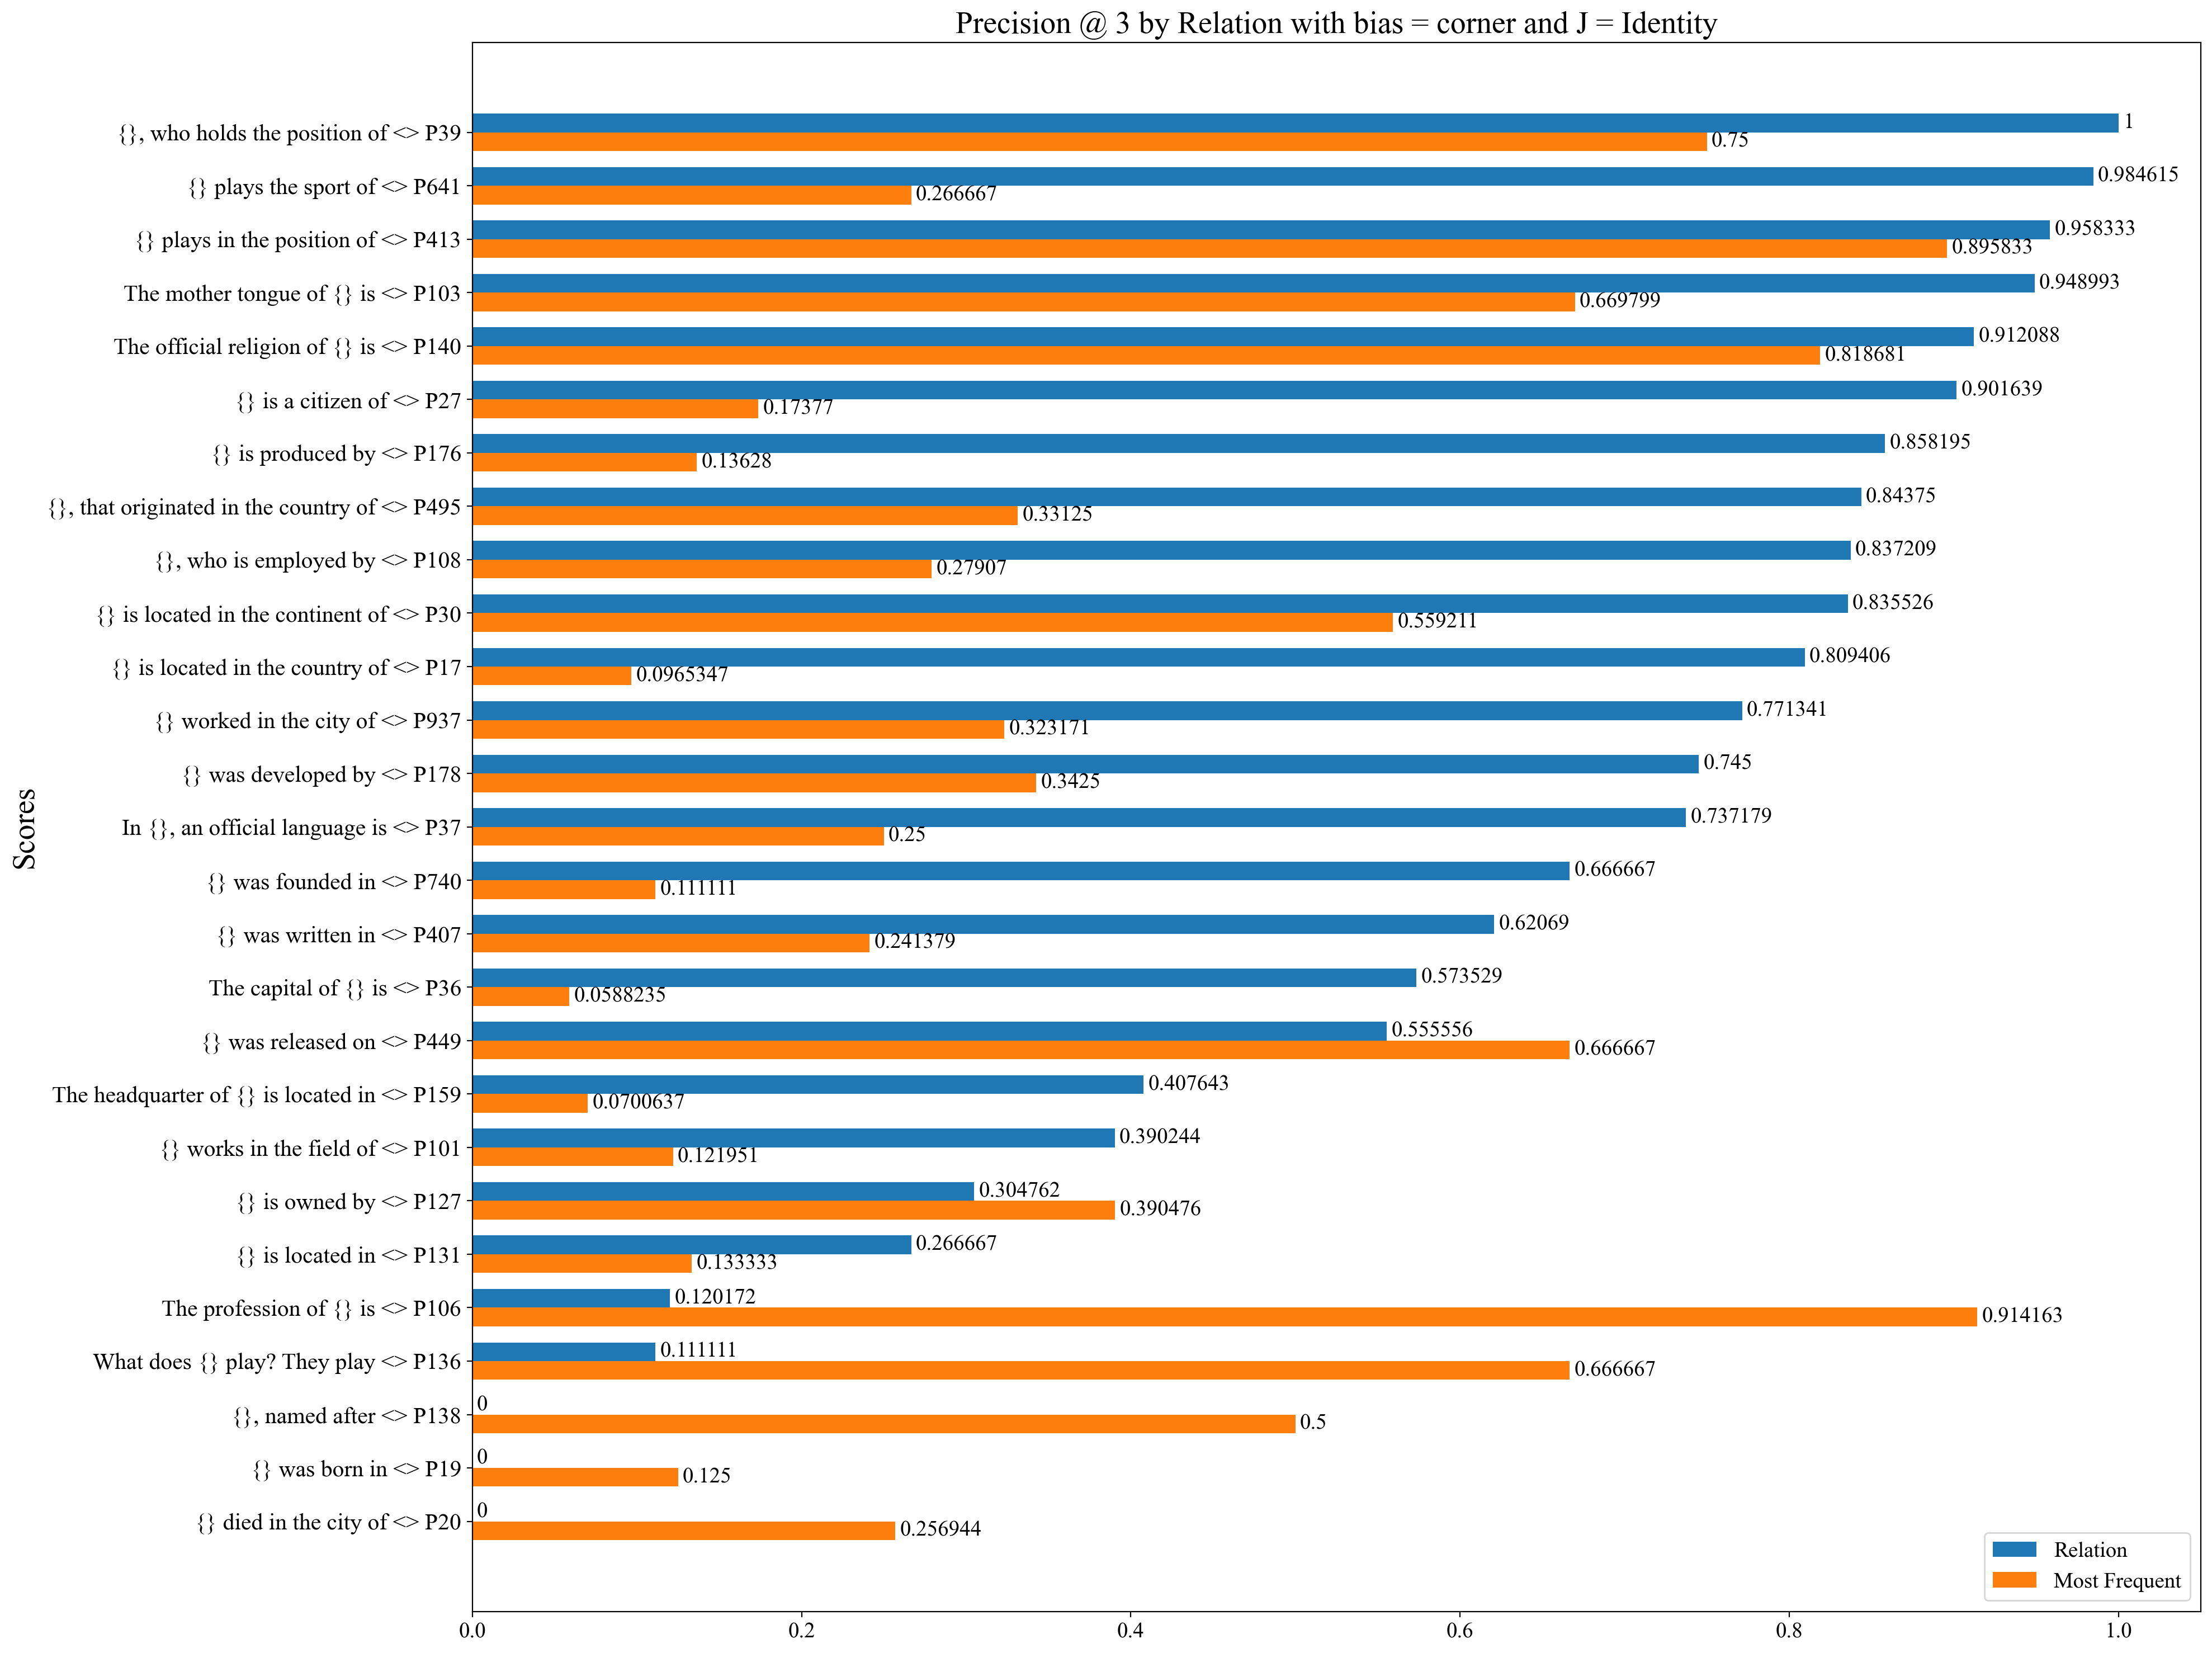

In [117]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

y = np.arange(len(relations))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, relation_accuracies, width, label='Relation')
rects2 = ax.barh(y - width/2, freq_accuracies, width, label='Most Frequent')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Precision @ 3 by Relation with bias = corner and J = Identity')
ax.set_yticks(y, relations)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()